<a href="https://colab.research.google.com/github/Baruls/harmful-language-detection-facebook-bert/blob/main/BERT_Train_Facebook_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Installation & Import

In [ ]:
!pip install transformers pandas tensorflow scikit-learn matplotlib seaborn -q
!pip install tensorflow==2.15.0

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.utils import class_weight

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


# 2. Load CSV File & Cleaning/Drop

In [ ]:
file_url = "https://www.dropbox.com/scl/fi/gcdkup5x7ppdb1mkh9ndy/fb-posts.csv?rlkey=osqmlbql6nzz1xidvdbtva810&st=wcaikser&dl=1"
file_path = "fb_posts.csv"
!wget -O {file_path} "{file_url}"

if not os.path.exists(file_path):
    print("ERROR: File gagal diunduh! Periksa kembali link Dropbox Anda.")
else:
    print(f"Berhasil memuat file: {file_path}")
    df = pd.read_csv(file_path)

    columns_to_drop = [
        'No', 'Post ID', 'Post Url', 'Comments Count', 'Reactions Count',
        'Name', 'Publication Date', 'LIKE', 'WOW', 'SUPPORT'
    ]
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    df.dropna(subset=['Message', 'LABEL'], inplace=True)

    df['LABEL'] = pd.to_numeric(df['LABEL'], errors='coerce')
    df.dropna(subset=['LABEL'], inplace=True)
    df['LABEL'] = df['LABEL'].astype(int)

    print("Data telah dibersihkan. Kolom yang tersisa:", df.columns.tolist())
    print("\nDistribusi Label:")
    print(df['LABEL'].value_counts())

--2025-07-23 08:39:39--  https://www.dropbox.com/scl/fi/gcdkup5x7ppdb1mkh9ndy/fb-posts.csv?rlkey=osqmlbql6nzz1xidvdbtva810&st=wcaikser&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uce7399d33ee3168464095b224e5.dl.dropboxusercontent.com/cd/0/inline/CuBZ03BZ1yx0pcNKbhmQBEJ9ItmPyh5mn20WgLwAJfWm_v-S2WA3PIopAh7XyJBjoSKnuaxpWPAxCrml0d6O35mqxqO8xZtEDdvXDVQh_LywY7A6B8UEui_arC7QU3Dnd3udvNlYRMcGpqrau-gZS2Ij/file?dl=1# [following]
--2025-07-23 08:39:40--  https://uce7399d33ee3168464095b224e5.dl.dropboxusercontent.com/cd/0/inline/CuBZ03BZ1yx0pcNKbhmQBEJ9ItmPyh5mn20WgLwAJfWm_v-S2WA3PIopAh7XyJBjoSKnuaxpWPAxCrml0d6O35mqxqO8xZtEDdvXDVQh_LywY7A6B8UEui_arC7QU3Dnd3udvNlYRMcGpqrau-gZS2Ij/file?dl=1
Resolving uce7399d33ee3168464095b224e5.dl.dropboxusercontent.com (uce7399d33ee3168464095b224e5.dl.dropboxuserconten

# 3. Data Splitting

In [ ]:
if 'history' in locals():
    loss, accuracy = model.evaluate(test_dataset.batch(16))
    print(f"\nHasil Evaluasi Model:")
    print(f"    -> Loss    : {loss:.4f}")
    print(f"    -> Akurasi : {accuracy:.4f} ({accuracy:.2%})")

    y_pred_logits = model.predict(test_dataset.batch(16)).logits
    y_pred = tf.argmax(y_pred_logits, axis=1).numpy()

    print("\n--- Metrik Kinerja Detail ---")
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test, y_pred, target_names=['Tidak Berbahaya (0)', 'Berbahaya (1)']))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

if 'df' in locals() and not df.empty:
    X = df['Message'].tolist()
    y = df['LABEL'].tolist()

    # Train
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y  # Prevent Imbalance
    )
    print(f"\nData berhasil dibagi: {len(X_train)} data latih dan {len(X_test)} data uji.")
else:
    print("Tidak ada data untuk diproses. Pastikan file Anda berisi data yang sudah dilabeli.")

13/13 [==============================] - 2s 150ms/step - loss: 0.5688 - accuracy: 0.7524

Hasil Evaluasi Model:
    -> Loss    : 0.5688
    -> Akurasi : 0.7524 (75.24%)
13/13 [==============================] - 2s 146ms/step

--- Metrik Kinerja Detail ---

Laporan Klasifikasi:
                     precision    recall  f1-score   support

Tidak Berbahaya (0)       0.80      0.87      0.84       149
      Berbahaya (1)       0.57      0.44      0.50        57

           accuracy                           0.75       206
          macro avg       0.69      0.66      0.67       206
       weighted avg       0.74      0.75      0.74       206


Confusion Matrix:
[[130  19]
 [ 32  25]]

Data berhasil dibagi: 824 data latih dan 206 data uji.


# 4. Tokenizer

In [ ]:
if 'df' in locals() and not df.empty:
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

    train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))
    print("Tokenisasi data selesai.")

Tokenisasi data selesai.


# 5. Load BERT Classification

In [ ]:
if 'df' in locals() and not df.empty:
    print("\nMemuat model TFBertForSequenceClassification...")
    model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Bobot Kelas Dihitung: {class_weights_dict}")

    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2, # Wait 2 epoch without increase val_loss
        restore_best_weights=True
    )

    print("Memulai proses training model...")
    history = model.fit(
        train_dataset.shuffle(1000).batch(16),
        epochs=10, # increase epoch by 10
        validation_data=test_dataset.batch(16),
        class_weight=class_weights_dict,
        callbacks=[early_stopping_callback]
    )
    print("Training model selesai.")


Memuat model TFBertForSequenceClassification...


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bobot Kelas Dihitung: {0: np.float64(0.692436974789916), 1: np.float64(1.7991266375545851)}
Memulai proses training model...
Epoch 1/10
52/52 [==============================] - 67s 559ms/step - loss: 0.6811 - accuracy: 0.5255 - val_loss: 0.5946 - val_accuracy: 0.6553
Epoch 2/10
52/52 [==============================] - 24s 463ms/step - loss: 0.5819 - accuracy: 0.6590 - val_loss: 0.6109 - val_accuracy: 0.6019
Epoch 3/10
52/52 [==============================] - 24s 467ms/step - loss: 0.4659 - accuracy: 0.7779 - val_loss: 0.5821 - val_accuracy: 0.6942
Epoch 4/10
52/52 [==============================] - 25s 475ms/step - loss: 0.3232 - accuracy: 0.8350 - val_loss: 0.5042 - val_accuracy: 0.7573
Epoch 5/10
52/52 [==============================] - 24s 451ms/step - loss: 0.1317 - accuracy: 0.9515 - val_loss: 0.6961 - val_accuracy: 0.7913
Epoch 6/10
52/52 [==============================] - 24s 457ms/step - loss: 0.1061 - accuracy: 0.9636 - val_loss: 1.0345 - val_accuracy: 0.7330
Training model se

# 6. Evaluation Output & Confusion Matrix (Plot)

13/13 [==============================] - 2s 144ms/step - loss: 0.5042 - accuracy: 0.7573

Hasil Evaluasi Model:
    -> Loss    : 0.5042
    -> Akurasi : 0.7573 (75.73%)
13/13 [==============================] - 5s 143ms/step

--- Metrik Kinerja Detail ---

Laporan Klasifikasi:
                     precision    recall  f1-score   support

Tidak Berbahaya (0)       0.88      0.77      0.82       149
      Berbahaya (1)       0.55      0.72      0.62        57

           accuracy                           0.76       206
          macro avg       0.71      0.75      0.72       206
       weighted avg       0.79      0.76      0.77       206


Confusion Matrix:
[[115  34]
 [ 16  41]]


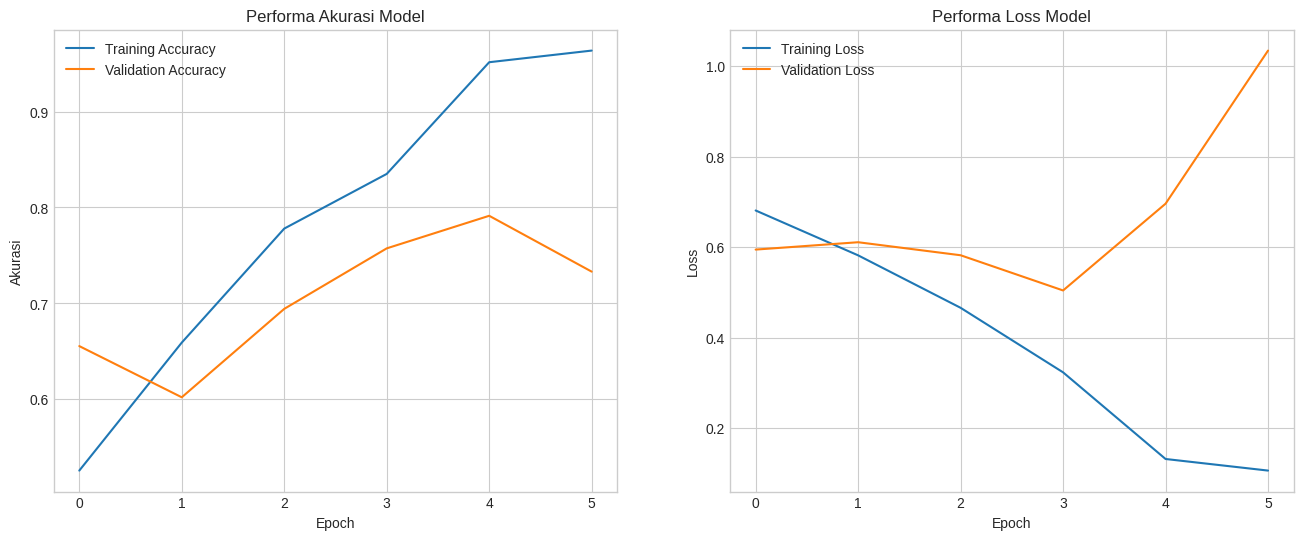

In [ ]:
if 'history' in locals():
    loss, accuracy = model.evaluate(test_dataset.batch(16))
    print(f"\nHasil Evaluasi Model:")
    print(f"    -> Loss    : {loss:.4f}")
    print(f"    -> Akurasi : {accuracy:.4f} ({accuracy:.2%})")

    y_pred_logits = model.predict(test_dataset.batch(16)).logits
    y_pred = tf.argmax(y_pred_logits, axis=1).numpy()

    print("\n--- Metrik Kinerja Detail ---")
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test, y_pred, target_names=['Tidak Berbahaya (0)', 'Berbahaya (1)']))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    history_df = pd.DataFrame(history.history)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(history_df['accuracy'], label='Training Accuracy')
    ax1.plot(history_df['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Performa Akurasi Model')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Akurasi')
    ax1.legend()

    ax2.plot(history_df['loss'], label='Training Loss')
    ax2.plot(history_df['val_loss'], label='Validation Loss')
    ax2.set_title('Performa Loss Model')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()


--- Metrik Kinerja Detail ---

Laporan Klasifikasi:
                     precision    recall  f1-score   support

Tidak Berbahaya (0)       0.88      0.77      0.82       149
      Berbahaya (1)       0.55      0.72      0.62        57

           accuracy                           0.76       206
          macro avg       0.71      0.75      0.72       206
       weighted avg       0.79      0.76      0.77       206



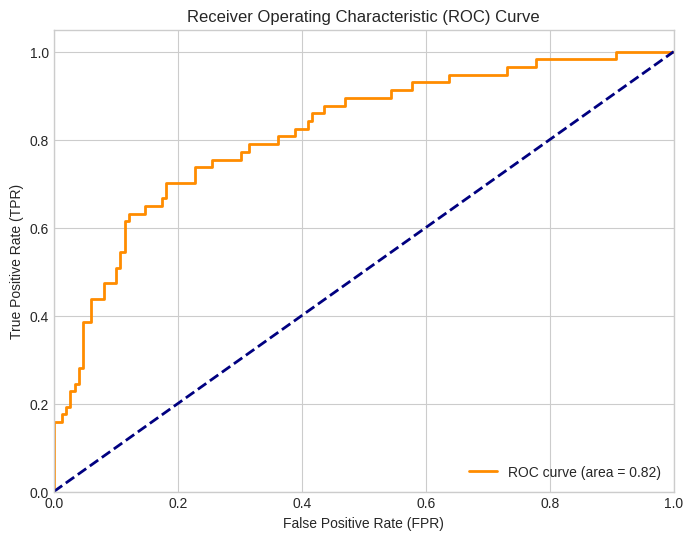

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = tf.nn.softmax(y_pred_logits, axis=1).numpy()
y_scores = y_pred_proba[:, 1]

print("\n--- Metrik Kinerja Detail ---")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Tidak Berbahaya (0)', 'Berbahaya (1)']))


# --- Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

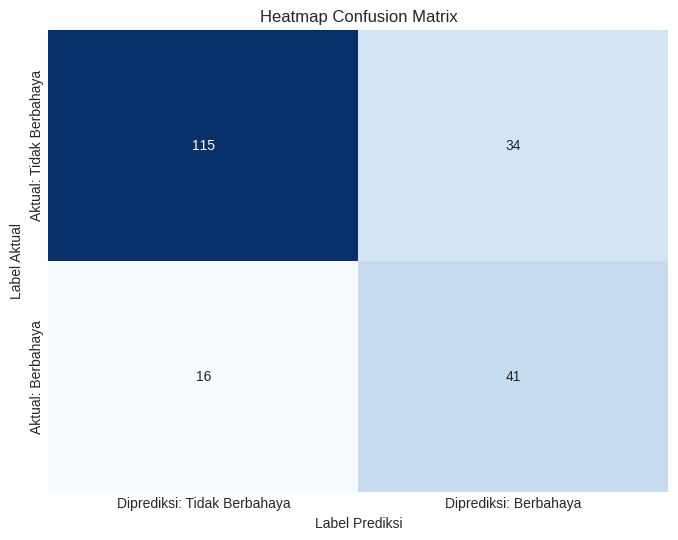

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Diprediksi: Tidak Berbahaya', 'Diprediksi: Berbahaya'],
            yticklabels=['Aktual: Tidak Berbahaya', 'Aktual: Berbahaya'])
plt.xlabel('Label Prediksi')
plt.ylabel('Label Aktual')
plt.title('Heatmap Confusion Matrix')
plt.show()